In [1]:
import pandas as pd
import sklearn as sklearn
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
import optuna
import optuna.integration.lightgbm as lgb
import xgboost as xgb
import pickle
import os
from datetime import date

from typing import List, TypeVar, Dict
from abc import ABC, abstractmethod

from sklearn.pipeline import Pipeline
from pandas.core.frame import DataFrame
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Helper functions

In [2]:
_СORRELATION_MATRIX_PATH_ = 'corr_matrix.pcl'
_СHURN_PATH_ = 'churn_model.pcl'
_CHURN_PATH_REDUCED_ = 'churn_model_reduced.pcl' 

In [3]:
def get_float_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(include=float).columns.tolist()

def get_int_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(include=int).columns.tolist()

def get_number_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(np.number).columns.tolist()

def get_obj_cols(df:DataFrame) -> List[str]:
    return list(df.select_dtypes(include=object).columns)

In [4]:
def reduce_mem_usage(df, verbose=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def split_test_train(df:DataFrame):
    test, train = df[df['ind'].eq('test')], df[df['ind'].eq('train')]
    test = test.drop(['ind'], axis=1)
    train = train.drop(['ind'], axis=1)
    return test, train
    
def combine_test_train(test:DataFrame, train:DataFrame):
    combine = pd.concat([test.assign(ind='test'), train.assign(ind='train')])
    target = train['target']
    test_ids = test['Id']
    return combine, target, test_ids

def combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi):
    df_combine = pd.concat([train_df.assign(ind='train'), test_df.assign(ind='test')])
    df_combine_num = pd.concat([train_num.assign(ind='train'), test_num.assign(ind='test')])
    df_combine_dpi = pd.concat([train_dpi.assign(ind='train'), test_dpi.assign(ind='test')])
    return df_combine, df_combine_num, df_combine_dpi

In [6]:
def reduce_churn_data():

    if os.path.exists(_CHURN_PATH_REDUCED_) == False:
        if os.path.exists(_СHURN_PATH_) == True: 
            
            with open(_СHURN_PATH_, 'rb') as file:
                deserialized_object = pickle.load(file)

            deserialized_object = list(deserialized_object)
        
            # reduce size
            train_df= reduce_mem_usage(deserialized_object[1][1])
            train_num_reduced = reduce_mem_usage(deserialized_object[1][2])
            train_dpi_reduced = reduce_mem_usage(deserialized_object[1][3])

            test_df = reduce_mem_usage(deserialized_object[2][1])
            test_num_reduced = reduce_mem_usage(deserialized_object[2][2])
            test_dpi_reduced = reduce_mem_usage(deserialized_object[2][3])
            
            # dump data back
            deserialized_object = tuple([[train_df, train_num_reduced, train_dpi_reduced], [test_df, test_num_reduced, test_dpi_reduced]])
            pickle.dump(deserialized_object, open(_CHURN_PATH_REDUCED_, 'wb'))
    else:
        print(f'{_CHURN_PATH_REDUCED_} already exist')

In [7]:
def load_churn_data():

    with open(_СHURN_PATH_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[1][1]
    train_num = deserialized_object[1][2]
    train_dpi = deserialized_object[1][3]

    test_df = deserialized_object[2][1]
    test_num = deserialized_object[2][2]
    test_dpi = deserialized_object[2][3]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [8]:
def load_churn_reduced():

    with open(_CHURN_PATH_REDUCED_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[0][0]
    train_num = deserialized_object[0][1]
    train_dpi = deserialized_object[0][2]

    test_df = deserialized_object[1][0]
    test_num = deserialized_object[1][1]
    test_dpi = deserialized_object[1][2]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [9]:
def is_short_number(number:str) -> bool:
    if (number.isdigit() and len(number) <= 4):
        return True
    return False

def is_life(number:str) -> bool:
    if (len(number) == 12 and (number[2:5] in ['063', '093' ])):
        return True
    return False

def is_kyivstar(number:str) -> bool:
    if (len(number) == 12 and (number[2:5] in ['067', '097', '068', '098'])):
        return True
    return False

### Feature selectors

In [10]:
class FeatureHelper:
    
    def get_correlation_matrix(df:DataFrame, method:str, save_path:str):
        if os.path.exists(save_path) == False:
            corr_matrix = df.corr(method = method, numeric_only = True)
            pickle.dump(corr_matrix, open(save_path, 'wb'))
        else:
            corr_matrix = pickle.load(open(save_path, 'rb'))

        return corr_matrix
    
    def remove_aggr_function(str_to_check:str) -> str:
        parts = str_to_check.split('_')
        if (len(parts) > 4):
            index_to_remove = len(parts) - 2
            parts.remove(parts[index_to_remove])
            result = '_'.join(parts)
            return result
        else:
            return str_to_check
        
    def get_heatmap_matrix(corr_matrix:DataFrame, target_filter:float):
        heatmap_matrix = pd.DataFrame(corr_matrix['target'].abs())
        heatmap_matrix = heatmap_matrix.sort_values(by='target', ascending=False)
        heatmap_matrix = heatmap_matrix.drop(index=['target'])
        heatmap_matrix = heatmap_matrix[heatmap_matrix['target'] > target_filter]
        return heatmap_matrix
    
    def plot_heatmap(heatmap_matrix:DataFrame):
        plt.figure(figsize=(40, 120))
        heatmap = sns.heatmap(heatmap_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
        heatmap.set_title('Features Correlating with Churn Rate', fontdict={'fontsize':18}, pad=16);
        return heatmap_matrix
    
    def get_important_features(heatmap_matrix:DataFrame):
        df_features = heatmap_matrix.reset_index()
        df_features = df_features.rename(columns = {'index':'feature'})
        df_features['feature_group'] = df_features['feature'].apply(FeatureHelper.remove_aggr_function)
        df_features = df_features[['feature', 'feature_group', 'target']]
        sorted_features = df_features.sort_values(by=['feature_group', 'target'], ascending = [False, False])
        important_features = sorted_features.groupby('feature_group').first()
        return important_features

In [11]:
class FeatureSelector(ABC):

    @classmethod
    @abstractmethod
    def get_heatmap(data:pd.DataFrame) -> pd.DataFrame:
        pass
    
    @classmethod
    @abstractmethod
    def plot_heatmap():
        pass
    
    @classmethod
    @abstractmethod
    def get_important_features() -> List[tuple[str, float]]:
        pass

In [12]:
class PearsonSelector(FeatureSelector):
    
    def get_heatmap(self, data:pd.DataFrame) -> pd.DataFrame:
        self.save_path = f'pearson_{_СORRELATION_MATRIX_PATH_}'
        self.corr_m = FeatureHelper.get_correlation_matrix(data, 'pearson', self.save_path)
        self.heatmap_m = FeatureHelper.get_heatmap_matrix(self.corr_m, 0.05)
        return self.heatmap_m
    
    def plot_heatmap(self):
        FeatureHelper.plot_heatmap(self.heatmap_m)

    def get_important_features(self) -> List[tuple[str, float]]:
        features = FeatureHelper.get_important_features(self.heatmap_m)
        return features

In [13]:
class SpearmanSelector(FeatureSelector):
    
    def get_heatmap(self, data:pd.DataFrame) -> pd.DataFrame:
        self.save_path = f'spearman_{_СORRELATION_MATRIX_PATH_}'
        self.corr_m = FeatureHelper.get_correlation_matrix(data, 'pearson', self.save_path)
        self.heatmap_m = FeatureHelper.get_heatmap_matrix(self.corr_m, 0.05)
        return self.heatmap_m
    
    def plot_heatmap(self):
        FeatureHelper.plot_heatmap(self.heatmap_m)

    def get_important_features(self) -> List[tuple[str, float]]:
        features = FeatureHelper.get_important_features(self.heatmap_m)
        return features

In [14]:
#class LGBSelector(FeatureSelector):
    

## Load Data

In [15]:
train_df, train_num, train_dpi, test_df, test_num, test_dpi = load_churn_reduced()
df_combine, df_combine_num, df_combine_dpi = combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi)

### Feature importance

In [16]:
# reduce size just for tests
result = Dict[str, List[str]]

selector = SpearmanSelector()
heatmap = selector.get_heatmap(df_combine)
features = selector.get_important_features()

In [17]:
# https://nitin9809.medium.com/lightgbm-binary-classification-multi-class-classification-regression-using-python-4f22032b36a2
# https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
test, train = split_test_train(df_combine)

y_train = train['target'].round(0).astype(int)
y_test = test['target'].round(0).astype(int)

train = train.drop(['target'], axis=1)
test = test.drop(['target'], axis=1)

regressor = lg.LGBMRegressor()
regressor.fit(train, y_train)
predicted = regressor.predict(test)
predicted = predicted.round(0).astype(int)

In [18]:
positives = list(df_combine[(df_combine['ind'] == 'test') & (df_combine['target'] == 1)].index)
negatives = list(df_combine[(df_combine['ind'] == 'test') & (df_combine['target'] == 0)].index)

In [19]:
print(f'MSE: {mean_squared_error(predicted, y_test)}')
print(f'ROCAUC: {roc_auc_score(predicted,y_test)}')

MSE: 0.051166666666666666
ROCAUC: 0.8389770419774625


In [20]:
df_feature_importance = pd.DataFrame(list(zip(list(regressor.feature_importances_), list(train.columns))))
df_feature_importance = df_feature_importance.set_axis(['score', 'name'], axis=1)

In [21]:
df_feature_importance.sort_values(by=['score'], ascending=False)

,score,name
632,121,loc_market_share
606,99,lt
634,67,device_days_usage
282,62,num_act_days_std_mnt3
480,52,num_act_days_mea_mnt3
...,...,...
368,0,all_roam_clc_td_mnt3
367,0,content_clc_std_mnt3
366,0,conn_com_part_min_mnt3
365,0,accum_mts_dur_min_mnt3


In [22]:
df_feature_importance[df_feature_importance['score'] > 20]

,score,name
110,22,all_cnt_std_mnt1
282,62,num_act_days_std_mnt3
287,31,num_act_days_td_mnt3
307,28,conn_in_uniq_cnt_std_mnt3
317,24,content_cnt_mea_mnt3
338,24,num_act_days_std_mnt1
480,52,num_act_days_mea_mnt3
488,47,num_act_days_mea_mnt1
525,22,all_cnt_mea_wk1
598,21,all_cnt_max_mnt3


### Check if dataset is balanced

In [23]:
churned = len(df_combine[df_combine['target'] == 1])
not_churned = len(df_combine[df_combine['target'] == 0])

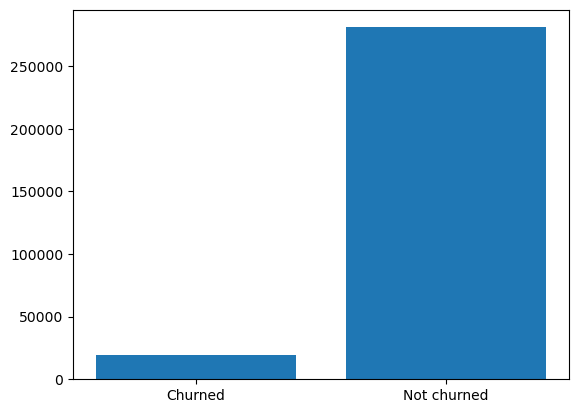

In [24]:
y = [churned, not_churned]
x = ['Churned', 'Not churned']
plt.bar(x,y)
plt.show()

## Feature engineering
#### Check inbound calls from non-vodaphone number
#### Check outbound calls to non-vodaphone number
#### SMS from non-vodaphone number
#### SMS to non-vodaphone number

## Correlation matrix

In [25]:
#heatmap_matrix = plot_heatmap(df_combine)
#important_features = get_important_features(df_combine)

## Explore numbers abonent had communication with + frequency

In [26]:
churned = df_combine[df_combine['target'] == 1]
churned_with_nums = pd.merge(churned, df_combine_num, on='abon_id', how='left')
churned_numbers = list(churned_with_nums['bnum'].unique())

non_churned = df_combine[df_combine['target'] == 0]
non_churned_with_nums = pd.merge(non_churned, df_combine_num, on='abon_id', how='left')
non_churned_numbers = list(non_churned_with_nums['bnum'].unique())

number_abon_had_communicated = (set(churned_numbers) - set(non_churned_numbers))
df_number_abon_had_communicated = pd.DataFrame(number_abon_had_communicated, columns= ['bnum'])

In [27]:
churned_with_nums[churned_with_nums['bnum'].isin(list(number_abon_had_communicated))]

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,abon_id,ind_x,bnum,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in,ind_y
102,0,0.0,9.671875,0.000000,0.000000,4.785156,0,14.468750,1.162109,0.000000,...,1933638.0,train,b'380679520201',0.000000,1.480469,0.000000,21.453125,0.000000,0.000000,train
305,0,0.0,11.617188,1.010742,0.000000,5.324219,0,11.804688,1.048828,2.570312,...,5280263.0,train,b'380979774316',1.480469,0.000000,15.320312,0.000000,0.000000,0.000000,train
471,0,0.0,14.789062,1.006836,1.043945,5.324219,0,18.984375,1.155273,24.765625,...,6400769.0,train,b'uaswitch',0.000000,0.000000,0.000000,0.000000,0.000000,3.589844,train
790,0,0.0,13.226562,0.000000,0.000000,5.324219,0,0.000000,0.000000,0.000000,...,9840437.0,train,b'affiliate',0.000000,0.000000,0.000000,0.000000,0.000000,6.750000,train
1099,0,0.0,10.265625,0.000000,1.019531,5.324219,0,0.000000,1.015625,14.328125,...,11590315.0,train,b'380442371358',1.480469,0.000000,26.046875,0.000000,0.000000,0.000000,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56153,0,0.0,11.617188,1.002930,1.009766,5.324219,0,14.085938,1.181641,11.617188,...,130192328.0,test,b'380444565002',1.480469,0.000000,11.359375,0.000000,0.000000,0.000000,test
56170,0,0.0,14.968750,1.011719,0.000000,5.324219,0,15.281250,1.476562,0.000000,...,130196216.0,test,b'380660203050',0.000000,0.000000,0.000000,0.000000,0.000000,1.480469,test
56202,0,0.0,9.351562,1.004883,0.000000,5.324219,0,0.000000,1.358398,11.617188,...,130200864.0,test,b'380444961496',2.921875,0.000000,22.921875,0.000000,0.000000,0.000000,test
56243,0,0.0,10.554688,1.006836,0.000000,5.324219,0,15.148438,1.136719,0.000000,...,130263832.0,test,b'4908',0.000000,0.000000,0.000000,0.000000,1.480469,0.000000,test


## Telephone Feature

## Groupping

In [28]:
gr = train_num.groupby(['abon_id'])
gr.groups

{1545052.0: [0, 1], 1545235.0: [2, 3, 4, 5, 6, 7], 1549591.0: [8], 1558772.0: [9, 10, 11], 1558921.0: [12, 13, 14], 1560464.0: [15, 16, 17, 18, 19, 20, 21, 22, 23], 1574321.0: [24, 25, 26, 27, 28], 1580281.0: [29, 30, 31], 1581064.0: [32, 33, 34, 35], 1582506.0: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], 1582902.0: [47, 48, 49, 50, 51], 1585461.0: [52, 53, 54, 55], 1586369.0: [56, 57, 58, 59, 60, 61], 1608877.0: [62, 63, 64, 65, 66, 67], 1610598.0: [68, 69, 70, 71, 72, 73, 74], 1610707.0: [75, 76, 77, 78, 79, 80, 81, 82, 83], 1611069.0: [84, 85, 86, 87], 1611112.0: [88, 89, 90], 1611873.0: [91, 92, 93], 1612053.0: [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110], 1613378.0: [111, 112, 113, 114, 115, 116, 117, 118], 1615091.0: [119, 120, 121, 122], 1616231.0: [123, 124, 125, 126, 127, 128], 1617311.0: [129, 130, 131, 132, 133, 134, 135, 136], 1617378.0: [137, 138, 139, 140, 141, 142, 143], 1618917.0: [144, 145, 146, 147], 1619052.0: [148, 149, 150], 161

In [29]:
# cor_matrix = train_df.corr()